In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import PIL

import os
import glob

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [13]:
# network parameters
width = 64
height = 64
latent_dim = 100


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(width,height,3), name='encoder_input')
x = GaussianNoise(0.5)(inputs) #Noise layer for denoising VAE
x = Conv2D(16, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)

(_,h,w,c) = x.shape

x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


# # build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(h*w*c, activation='relu')(latent_inputs)
x = Reshape((h,w,c))(x)
x = Conv2D(64,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(64,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(32,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(16,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)

outputs = Conv2D(3,3, strides=1, activation='sigmoid', padding='same')(x)


# # instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# # instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='cnn_vae')
vae.summary()
history = []

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, 64, 64, 3)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 16)   448         gaussian_noise_3[0][0]           
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 32, 32, 16)   64          conv2d_27[0][0]                  
____________________________________________________________________________________________

In [14]:
#Beta VAE warmup
from tensorflow.keras.callbacks import Callback
class Warmup(Callback):
    def __init__(self, beta, warmup_epoch):
        self.warmup_epoch = warmup_epoch
        self.beta = beta

    def on_epoch_end(self, epoch, logs={}):
        value = (epoch/self.warmup_epoch) * (epoch <= self.warmup_epoch) + 1.0 * (epoch > self.warmup_epoch)
        K.set_value(self.beta, value)
        print(f' epoch {epoch}, beta = {K.get_value(self.beta)}')

def vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss * beta
    return K.mean(reconstruction_loss + kl_loss)
    


beta = K.variable(0.0)
optimizer = Adam(0.0005)

vae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False)

In [ ]:
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=False)

# validation_generator = training_data_generator.flow_from_directory(
#    './Birds-200-2011/',
#     target_size=(width, height),
#     subset='validation',
#     batch_size=32,
#     class_mode='input')

training_generator = training_data_generator.flow_from_directory(
   './celeba/',
    target_size=(width, height),
    subset='training',
    shuffle=True,
    batch_size=32,
    class_mode='input')

In [107]:
import cv2
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)
X = data_loader('./CUB_200_2011/cleaned-birds/training')

In [16]:
epochs = 15

history_dict = vae.fit_generator(training_generator, epochs=epochs, callbacks=[Warmup(beta, 5)])
#history_dict = vae.fit(X, epochs=epochs,batch_size=32, shuffle=True,callbacks=[wu_cb])
history += history_dict.history['loss']

Epoch 1/15
634/634 [==============================] - 18s 28ms/step - loss: 2.2896
Epoch 2/15
634/634 [==============================] - 15s 23ms/step - loss: 0.1291
Epoch 3/15
634/634 [==============================] - 15s 23ms/step - loss: 0.1053
Epoch 4/15
634/634 [==============================] - 15s 23ms/step - loss: 0.0977
Epoch 5/15
634/634 [==============================] - 15s 23ms/step - loss: 0.0955
Epoch 6/15
634/634 [==============================] - 15s 23ms/step - loss: 0.0931
Epoch 7/15
634/634 [==============================] - 15s 23ms/step - loss: 0.0922
Epoch 8/15
634/634 [==============================] - 15s 23ms/step - loss: 0.0910
Epoch 9/15
634/634 [==============================] - 15s 23ms/step - loss: 0.0899
Epoch 10/15
634/634 [==============================] - 15s 23ms/step - loss: 0.0884
Epoch 11/15
634/634 [==============================] - 15s 23ms/step - loss: 0.0883
Epoch 12/15
634/634 [==============================] - 15s 23ms/step - loss: 0.0869
E

In [233]:
beta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>

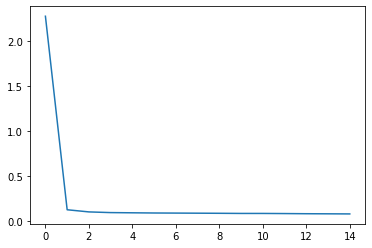

In [17]:
plt.plot(history)

In [19]:
imgs = training_generator.next()[0]

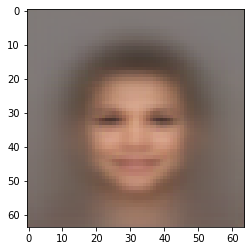

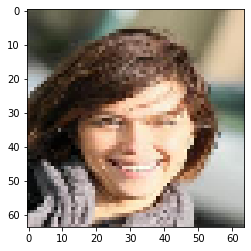

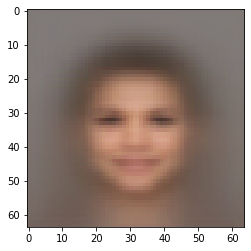

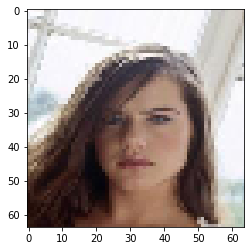

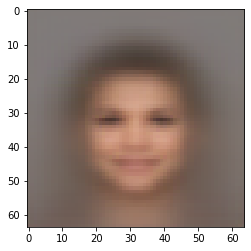

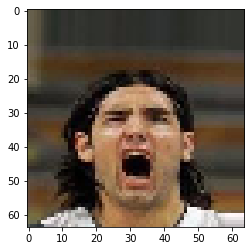

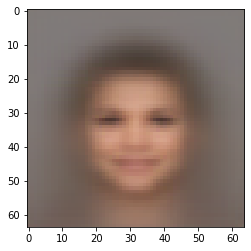

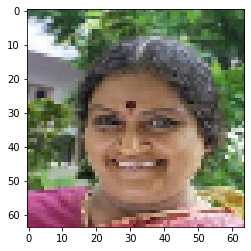

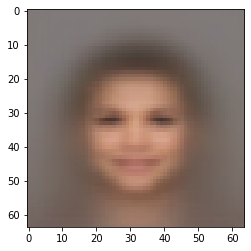

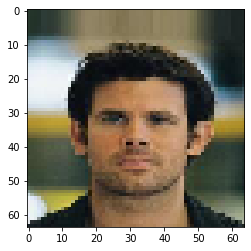

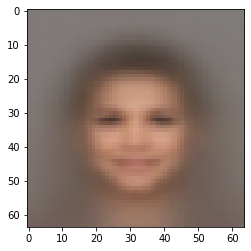

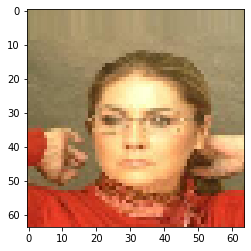

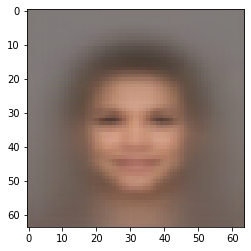

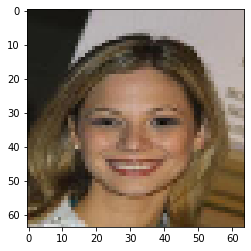

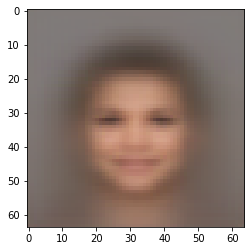

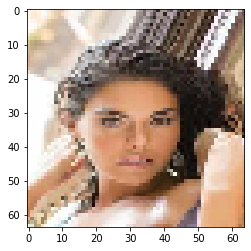

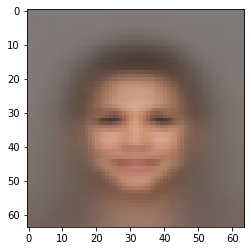

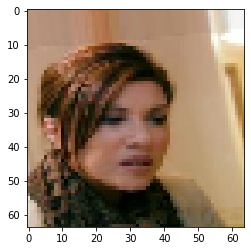

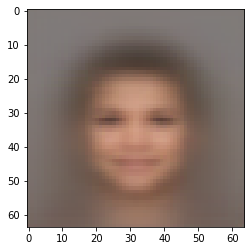

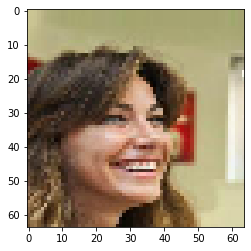

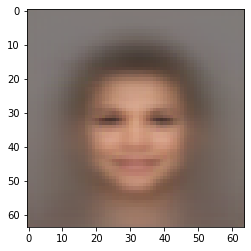

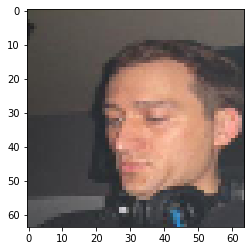

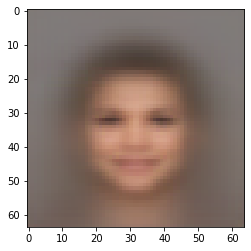

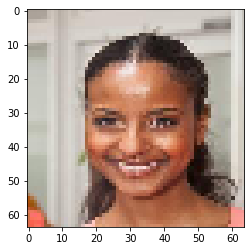

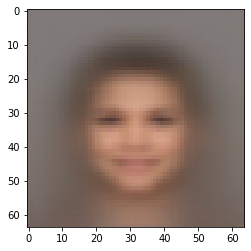

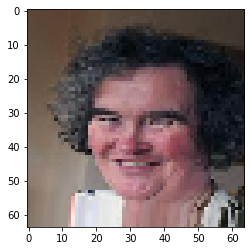

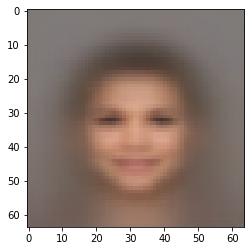

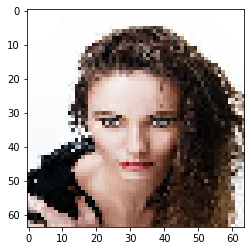

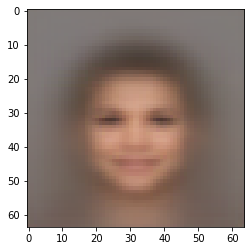

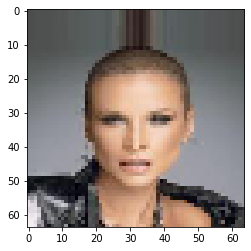

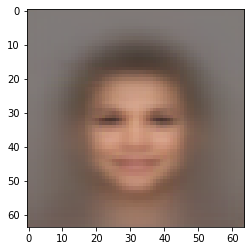

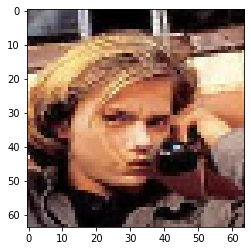

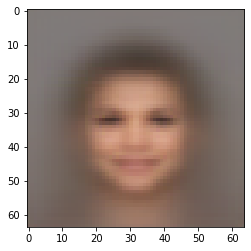

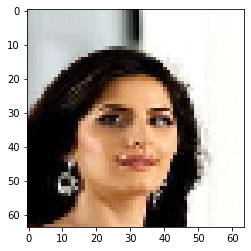

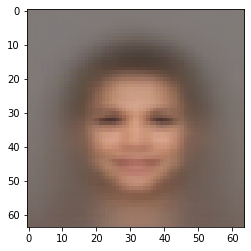

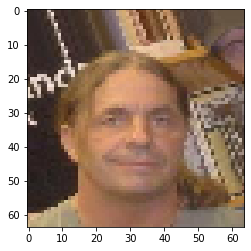

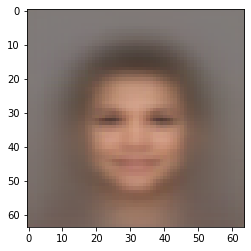

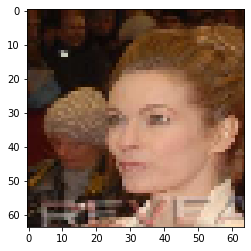

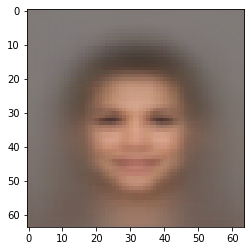

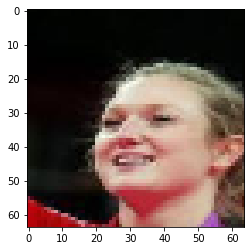

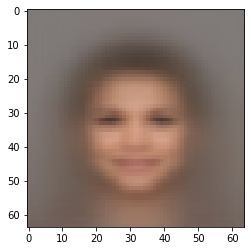

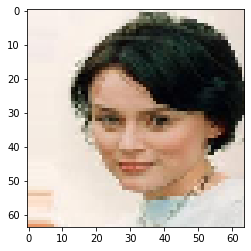

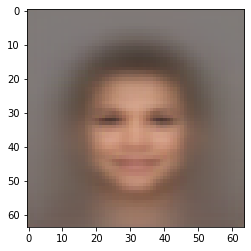

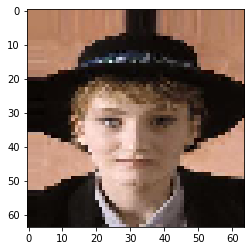

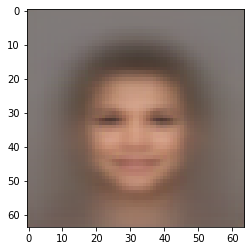

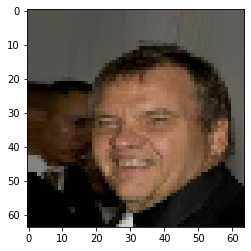

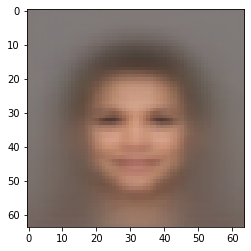

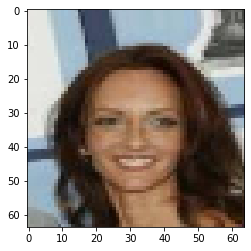

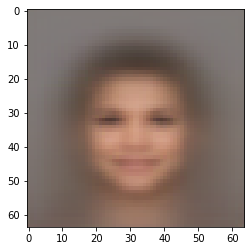

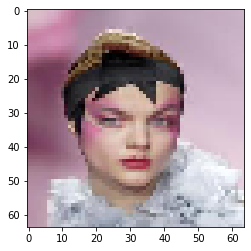

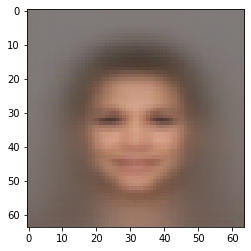

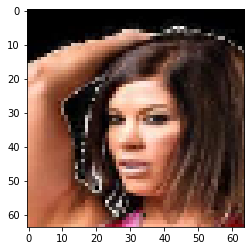

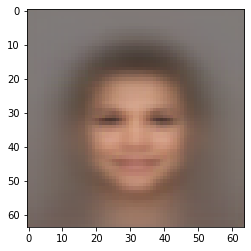

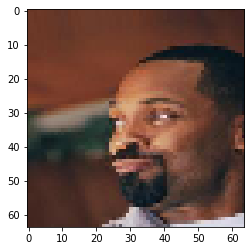

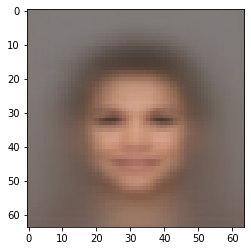

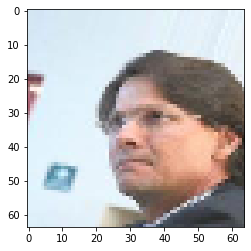

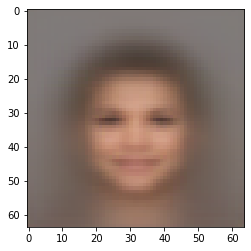

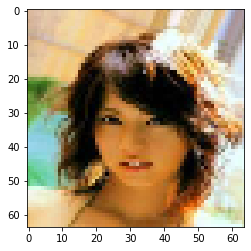

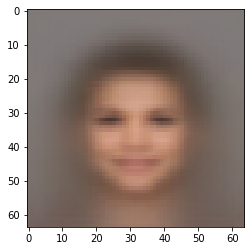

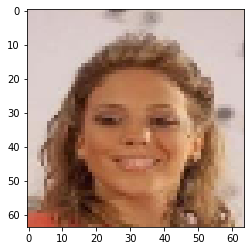

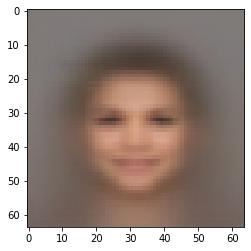

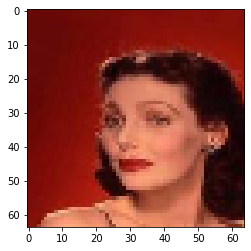

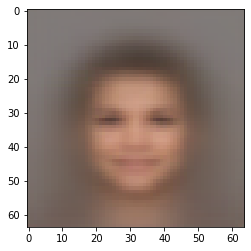

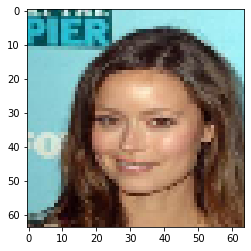

In [20]:
for idx in range(32):
    generated = vae.predict(np.array([imgs[idx]]))[0]
    actual = imgs[idx]

    plt.imshow(generated)
    plt.show()
    plt.imshow(actual)
    plt.show()

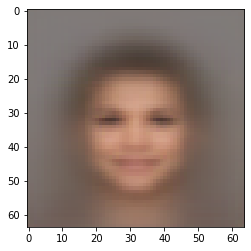

In [28]:
mu, sigma = 0, 1 #mean and standard deviation
s = np.random.normal(mu, sigma, latent_dim)
plt.imshow(decoder.predict(np.array([s]))[0])
plt.show()

In [130]:
vae.save('beta-generatesnothing-DVAE-150.h5', save_format='tf')

In [124]:
encoded = encoder.predict(np.array([imgs[idx]]))[0]

In [129]:
warmup_til_epoch=50
for epoch in range(100):
    value = (epoch/warmup_til_epoch) * (epoch <= warmup_til_epoch) + 1.0 * (epoch > warmup_til_epoch)
    print(value)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [126]:
s

array([-1.08106999,  0.32013323, -1.55818613, -0.45026854, -1.66310395,
        0.78569422, -1.39762405,  0.07338019,  1.1939133 ,  0.4395131 ,
        0.84212601,  0.72813559, -0.20395568, -0.55190861,  0.91331887,
       -0.52396943,  0.42840624,  1.52424608, -1.03515727, -0.56327838,
       -0.20883481,  0.21993302,  0.42961978, -0.23346862,  0.41999356,
       -1.33034769,  0.45838368,  0.56152947, -0.03538979, -1.64144032,
       -0.4171319 ,  1.4437737 , -0.3009611 ,  1.4147419 ,  0.37861709,
        0.51136094, -1.66606614, -0.78132097,  0.26521417, -2.84087669,
        0.14570408, -1.30468342,  1.07145666, -0.19641146, -0.79491905,
       -0.68028141,  0.07673936, -1.65081373,  0.41551591, -1.56793549,
       -0.53741953,  1.91968439, -0.45774273, -0.3253923 ,  0.26121327,
       -1.80431887, -1.50881659, -1.12793814,  0.41378639, -0.40247553,
        1.61163988,  0.21441996, -0.7190945 ,  0.32763873,  0.1133167 ,
       -0.7985691 ,  1.21927564, -0.06176024,  0.15438005, -0.24